# Week 4: Fitting (sub)halo mass function suppression

### Imports

In [1]:
import numpy as np
import pickle
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist
import matplotlib.pylab as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
plt.rc("text", usetex=True)
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]

sim_colors = {}
sim_colors['cdm'] = 'k'
sim_colors['wdm_3'] = custom_blues_complement[0]
sim_colors['wdm_4'] = custom_blues_complement[1]
sim_colors['wdm_5'] = custom_blues_complement[2]
sim_colors['wdm_6'] = custom_blues_complement[3]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['wdm_10'] = custom_blues_complement[5]

### Load data

In [2]:
with open("/central/groups/carnegie_poc/enadler/ncdm_resims/analysis/sim_data.bin", "rb") as f:
    sim_data = pickle.load(f, encoding='latin1')

## Measure differential halo mass function suppression at $z=0$

This is an example of how to calculate differential halo mass function suppression (for a particular realization and model). The code is written so as to be generalizable to other models and realizations.

In [3]:
h = 0.7 #H0 in units of 100 km/s/Mpc
m_part = 3e5 #particle mass, Msun/h

#...... particle limits?
lower_limit=300 
upper_limit=1.3e4

bin_number=10
base_mpeak = np.logspace(np.log10(m_part/h*lower_limit),np.log10(m_part/h*upper_limit),bin_number)

def get_shmf(masses,bins):
    values_mpeak, base_mpeak = np.histogram(masses,bins)
    return values_mpeak/(base_mpeak[1:]-base_mpeak[0:-1]), values_mpeak, base_mpeak

In [4]:
model = 'wdm_3'
halo = 'Halo004'

In [5]:
cdm_shmf = {}
wdm_shmf = {}

wdm_shmf_suppression = {}
wdm_shmf_suppression_err = {}

###

cdm_shmf[model] = {}
cdm_shmf[model]['phi'] = []
cdm_shmf[model]['N'] = []

wdm_shmf[model] = {}
wdm_shmf[model]['phi'] = []
wdm_shmf[model]['N'] = []

###

#...... distances of isolated halo pop from host halo
distances = np.sqrt((sim_data[halo]['cdm'][1]['x']-sim_data[halo]['cdm'][0]['x'][0])**2+(sim_data[halo]['cdm'][1]['y']-sim_data[halo]['cdm'][0]['y'][0])**2+(sim_data[halo]['cdm'][1]['z']-sim_data[halo]['cdm'][0]['z'][0])**2)
#...... mass and distance cut; 900e5 Msun/h, 3 Mpc
ind_cdm = (sim_data[halo]['cdm'][1]['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)
#...... getting shmf
cdm_temp = get_shmf(sim_data[halo]['cdm'][1]['Mpeak'][ind_cdm]/h,base_mpeak)

cdm_shmf[model]['phi'].append(cdm_temp[0]) # shmf, N/N_cdm for discrete mass
cdm_shmf[model]['N'].append(cdm_temp[1]) # shmf, values
  
#...... same process, warm dark matter
distances = np.sqrt((sim_data[halo][model][1]['x']-sim_data[halo][model][0]['x'][0])**2+(sim_data[halo][model][1]['y']-sim_data[halo][model][0]['y'][0])**2+(sim_data[halo][model][1]['z']-sim_data[halo][model][0]['z'][0])**2)
ind = (sim_data[halo][model][1]['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)
wdm_temp = get_shmf(sim_data[halo][model][1]['Mpeak'][ind]/h,base_mpeak)
wdm_shmf[model]['phi'].append(wdm_temp[0])
wdm_shmf[model]['N'].append(wdm_temp[1])

### Poisson error on the mean; when combining different realizations, 
#...... note that the upper and lower error are symmetrical/the same

yerr_lower = (1./(np.sqrt(np.mean(wdm_shmf[model]['N'],axis=0))))*np.mean(wdm_shmf[model]['phi'],axis=0)/np.mean(cdm_shmf[model]['phi'],axis=0)
yerr_upper = (1./(np.sqrt(np.mean(wdm_shmf[model]['N'],axis=0))))*np.mean(wdm_shmf[model]['phi'],axis=0)/np.mean(cdm_shmf[model]['phi'],axis=0)

###

wdm_shmf_suppression[model] = np.mean(wdm_shmf[model]['phi'],axis=0)/np.mean(cdm_shmf[model]['phi'],axis=0)
wdm_shmf_suppression_err[model] = np.amax(np.vstack((yerr_lower,yerr_upper)),axis=0)

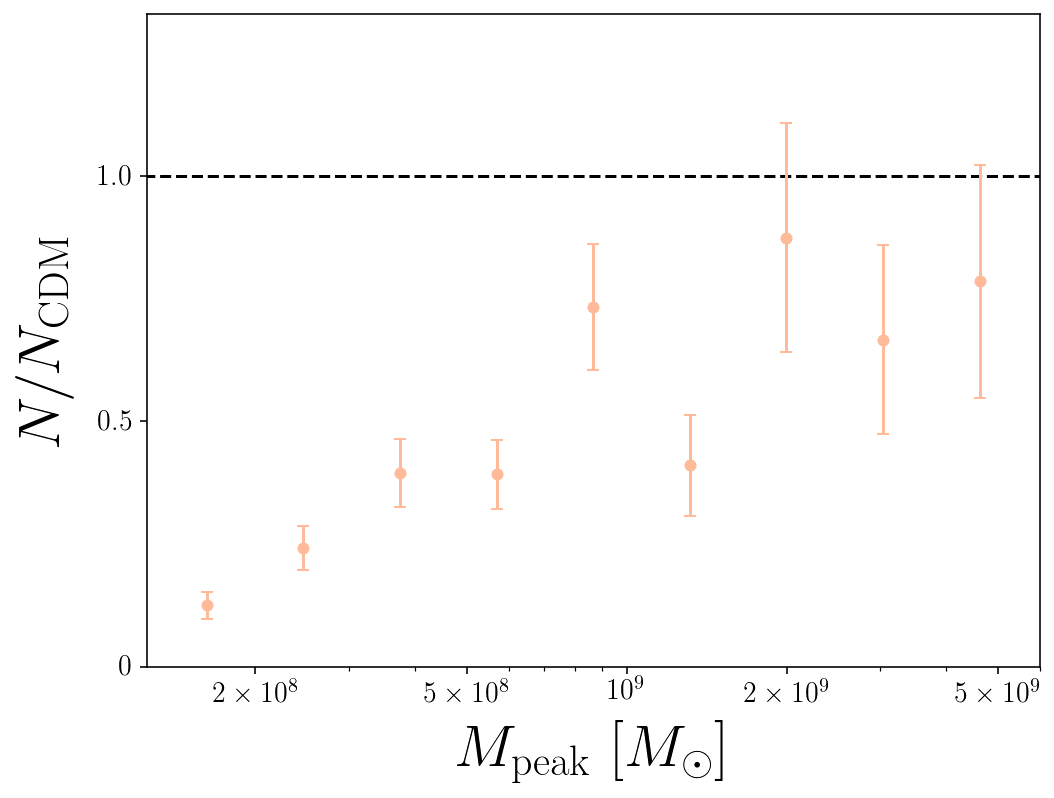

In [6]:
plt.figure(figsize=(8,6))
plt.xscale('log')

###

plt.plot(np.linspace(1e8,6e9,10),np.ones(10),ls='--',c='k') # line at 1.0

# isolated suppression function
plt.scatter(0.5*(base_mpeak[1:]+base_mpeak[:-1]),wdm_temp[0]/cdm_temp[0],
            marker='o',color=sim_colors[model],s=10)

# error bars
plt.errorbar(0.5*(base_mpeak[1:]+base_mpeak[:-1]),wdm_shmf_suppression[model],yerr=wdm_shmf_suppression_err[model],
             linestyle='none',marker='.',markersize=10,capsize=3,color=sim_colors[model])

###

plt.xticks([2e8,5e8,1e9,2e9,5e9],[r'$2\times 10^8$',r'$5\times 10^8$',r'$10^9$',r'$2\times 10^9$',r'$5\times 10^9$'],fontsize=14)
plt.yticks([0,0.5,1.0],[r'$0$',r'$0.5$',r'$1.0$'], fontsize=14)

plt.xlim(1.25e8,6e9)
plt.ylim(0,1.33)

plt.xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
plt.ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)

plt.show()

## Model differential halo mass function suppression at $z=0$ (optional)

Next, let's add an analytic model for the differential halo mass function suppression. There are a few ingredients:

* Warm dark matter transfer function $T_{\mathrm{WDM}}(k)$, modeled using Equations (8) and (9) [here](https://arxiv.org/pdf/2210.10753.pdf#page=4) and defined as:

    $T_{\mathrm{WDM}}(k) = \sqrt{\frac{P_{\mathrm{WDM}}(k,m_{\mathrm{WDM}})}{P_{\mathrm{CDM}}(k)}}$, where $P(k)$ is the linear matter power spectrum.

* Half-mode scale, defined as:

    $T^2(k_{\mathrm{hm}})=0.25$
    
* Half-mode mass, defined as:

    $M_{\mathrm{hm}} = \frac{4\pi}{3}\Omega_m\bar{\rho}\left(\frac{\pi}{k_{\mathrm{hm}}}\right)^3$, where $\Omega_m$ is the fraction of the cosmic energy density in matter and $\bar{\rho}$ is the mean density of the universe today.
    
* Subhalo mass function suppression model, defined following Equation (8) [here](https://arxiv.org/pdf/1308.1399.pdf#page=10):

    $f_{\mathrm{WDM}}(M,m_{\mathrm{WDM}}) = \frac{\mathrm{d}n_{\mathrm{WDM}}/\mathrm{d}M}{\mathrm{d}n_{\mathrm{CDM}}/\mathrm{d}M} = \left[1+\left(\frac{\alpha M_{\mathrm{hm}}(m_{\mathrm{WDM}})}{M}\right)^\beta\right]^{-\gamma}$, where $\alpha$, $\beta$, and $\gamma$ are free parameters, set to the Lovell et al. values for now.

In [7]:
def transfer(k, mwdm, a = 0.0292, b = -1.188, nu = 1.049, theta = 2.012, eta = 0.2463, omega_m=0.286, h=0.7):
    alpha = a*(mwdm**b)*((omega_m*h*h/0.12)**eta)*((h/0.6736)**theta)
    transfer = (1+(alpha*k)**(2*nu))**(-5./nu)
    return transfer

def khm(mwdm, k_array=np.logspace(0,3,1000), h=0.7):
    return k_array[np.argmin(np.abs(transfer(k_array,mwdm)**2-0.25))]*h

def Mhm(mwdm, omega_m = 0.286, h=0.7):
    rho_m = 1.36*10**11*omega_m
    return (4.*np.pi*rho_m/3.)*((2.*np.pi/(khm(mwdm)*h))/2.)**3.

def shmf_suppression(M,mwdm,alpha=2.7,beta=1.,gamma=0.99):
    return (1.+(alpha*(Mhm(mwdm))/(M))**beta)**(-1.*gamma)

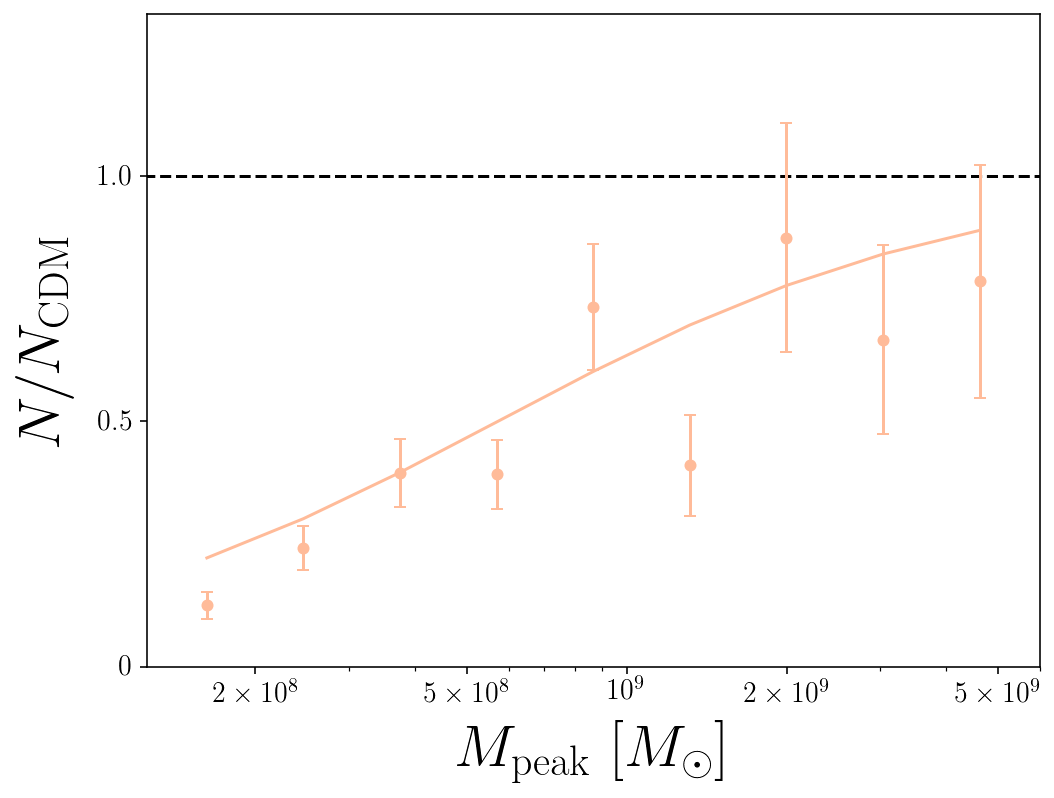

In [8]:
plt.figure(figsize=(8,6))
plt.xscale('log')

###

plt.plot(np.linspace(1e8,6e9,10),np.ones(10),ls='--',c='k')

plt.scatter(0.5*(base_mpeak[1:]+base_mpeak[:-1]),wdm_temp[0]/cdm_temp[0],
            marker='o',color=sim_colors[model],s=10)

plt.errorbar(0.5*(base_mpeak[1:]+base_mpeak[:-1]),wdm_shmf_suppression[model],yerr=wdm_shmf_suppression_err[model],
             linestyle='none',marker='.',markersize=10,capsize=3,color=sim_colors[model])

plt.plot(0.5*(base_mpeak[1:]+base_mpeak[:-1]),(1.+(2.7*(Mhm(3.))/(1.*(base_mpeak[1:]+base_mpeak[:-1])))**1)**-0.99,
            c=sim_colors[model])

###

plt.xticks([2e8,5e8,1e9,2e9,5e9],[r'$2\times 10^8$',r'$5\times 10^8$',r'$10^9$',r'$2\times 10^9$',r'$5\times 10^9$'],fontsize=14)
plt.yticks([0,0.5,1.0],[r'$0$',r'$0.5$',r'$1.0$'], fontsize=14)

plt.xlim(1.25e8,6e9)
plt.ylim(0,1.33)

plt.xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
plt.ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)

plt.show()

## Fit differential halo mass function suppression at $z=0$ (optional)

In [11]:
import corner
import emcee
from chainconsumer import ChainConsumer

In [17]:
def log_likelihood(theta, x=0.5*(base_mpeak[1:]+base_mpeak[:-1])):#, wdm_shmf_suppression, wdm_shmf_suppression_err):
    alpha, beta, gamma = theta
    lnlike = 0.
    mass = 3.
    model = 'wdm_3'
    shmf_model = (1.+(alpha*Mhm(3.)/x)**beta)**(-1.*gamma)
    lnlike += -0.5*np.sum((wdm_shmf_suppression[model]-shmf_model)**2/wdm_shmf_suppression_err[model]**2 + np.log(wdm_shmf_suppression_err[model]**2))
    return lnlike

def log_prior(theta):
    alpha, beta, gamma = theta
    if 0. < gamma < 5. and 0. < alpha < 50. and 0. < beta < 10.:
        return np.log(1.0/(1.0+(beta**2))) + np.log(1.0/(1.0+(gamma**2)))
    return -np.inf

def log_probability(theta):#, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)#, x, y, yerr)

In [18]:
x0=np.array([2.7, 1., 0.99])

pos = x0 + 1e-2 * np.random.randn(100, 3) # posterior function?
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)#, args=(x, y, yerr))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [04:06<00:00, 40.55it/s]


best fit values:
[1.98031917 1.12765132 0.86783927]


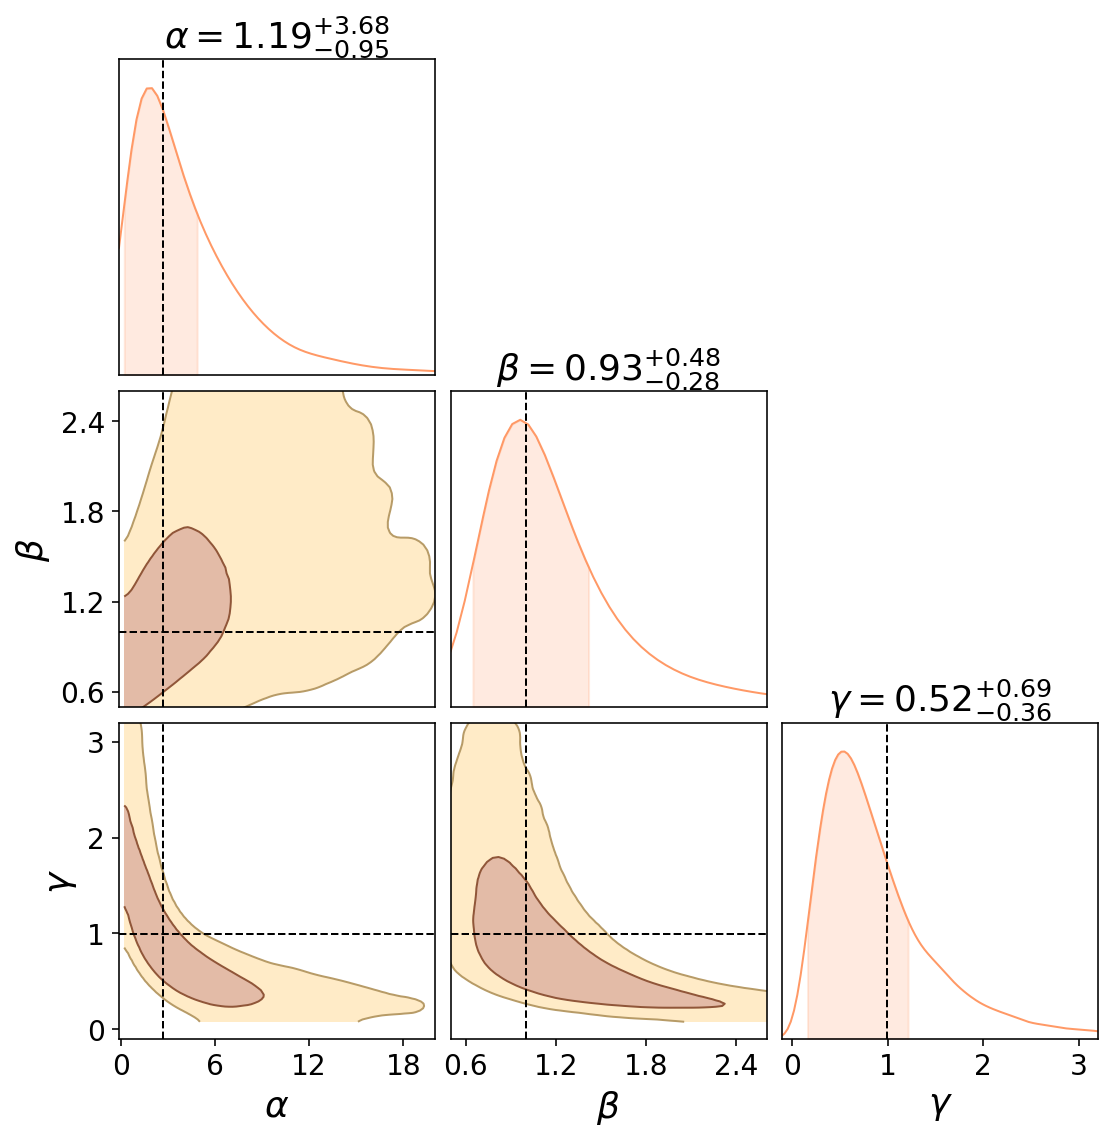

In [19]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
print('best fit values:')
print(flat_samples[np.argmax(sampler.get_log_prob(discard=1000, flat=True).shape)])

labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

c = ChainConsumer()
c.add_chain(flat_samples, parameters=[r"$\alpha$", r"$\beta$", r"$\gamma$"])

c.configure(colors=[sim_colors['wdm_4'], sim_colors['wdm_5']], shade=[True,False], shade_alpha=0.5, bar_shade=True,spacing=1.0,
                diagonal_tick_labels=False, tick_font_size=14, label_font_size=18, sigma2d=False,max_ticks=4, 
                summary=True,kde=False)
fig = c.plotter.plot(figsize=(8,8), extents=[[-0.1,20],[0.5,2.6],[-0.1,3.2]], truth=[2.7,1.,0.99],display=True)

## Exercises

### 1. Measure (sub)halo mass function suppression versus redshift

* Measure the differential (sub)halo mass function suppression versus redshift, using tools from previous weeks to load `hlists` at $z>0$. 

* Plot the suppression at a fixed $M_{\mathrm{peak}}$, as a function of $z$.

* Repeat using $M_{\mathrm{vir}}(z)$ rather than $M_{\mathrm{peak}}$.

* Repeat for other models and realizations.

In [1]:
#......new imports (helper class)
import sys
sys.path.insert(0, '../scripts') # adding to the system path
from hlistHelper import hlist

#...... loading in cdm/wdm models
halo_id = 'Halo004'

#...... cold dark matter
model = 'cdm'
cdm = hlist(halo_id=halo_id, model=model)
cdm.load_hlists()
cdm.load_hmb()

#...... warm dark matter, 3 keV
model = 'wdm_3'
wdm = hlist(halo_id=halo_id, model=model)
wdm.load_hlists()
wdm.load_hmb()


### 2. Model (sub)halo mass function suppression as a function of redshift (optional)

* Using the standard form of $f_{\mathrm{WDM}}(M,m_{\mathrm{WDM}})$ defined above, try measuring how $\alpha$, $\beta$, and/or $\gamma$ change as a function of redshift.

### 3. Fit (sub)halo mass function suppression as a function of redshift (optional)

* Parameterize $f_{\mathrm{WDM}}(z,M_{\mathrm{peak}}=M_0)$ as a function of $z$, for a fixed $M_0$ (e.g. $M_0=5\times 10^8~M_{\mathrm{\odot}}$). This can be an arbitrary function of $z$, rather than being tied to $m_{\mathrm{WDM}}$. Fit for the parameters of this model.

* Using the standard form of $f_{\mathrm{WDM}}(M,m_{\mathrm{WDM}})$ defined above, parameterize $\alpha$, $\beta$, and $\gamma$ as functions of redshift. Fit for their redshift evolution.